# Imports

In [3]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.8/758.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.2/314.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 826.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Phase 0: Data exploration

In [5]:
df = pd.read_csv('normalization_assesment_dataset_10k.csv')
df


,raw_comp_writers_text,CLEAN_TEXT
0,Jordan Riley/Adam Argyle/Martin Brammer,Jordan Riley/Adam Argyle/Martin Brammer
1,Martin Hygård,Martin Hygård
2,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...
3,Mendel Brikman,NaN
4,Alvin Lee,Alvin Lee
...,...,...
9995,Terrance Byrd,Terrance Byrd
9996,Pillar Point,Pillar Point
9997,FRANK BRIAN KEITH (MR)/JENNINGS JOHN JOSEPH IV...,FRANK/BRIAN/KEITH/(MR)/JENNINGS/JOHN/JOSEPH/IV...
9998,Sierra Lucas,Sierra Lucas


## Basic Statistics


1. BASIC STATISTICS
Dataset size: 10,000 samples

NaN count per column:
 raw_comp_writers_text: 1
 CLEAN_TEXT: 1341

Total rows with NaN: 1,341 (13.4)%
Total missing values: 1,342 (6.7)%

Rows already normalized: 6,323 (63.2%)
Rows that need processing: 3,677 (36.8%)



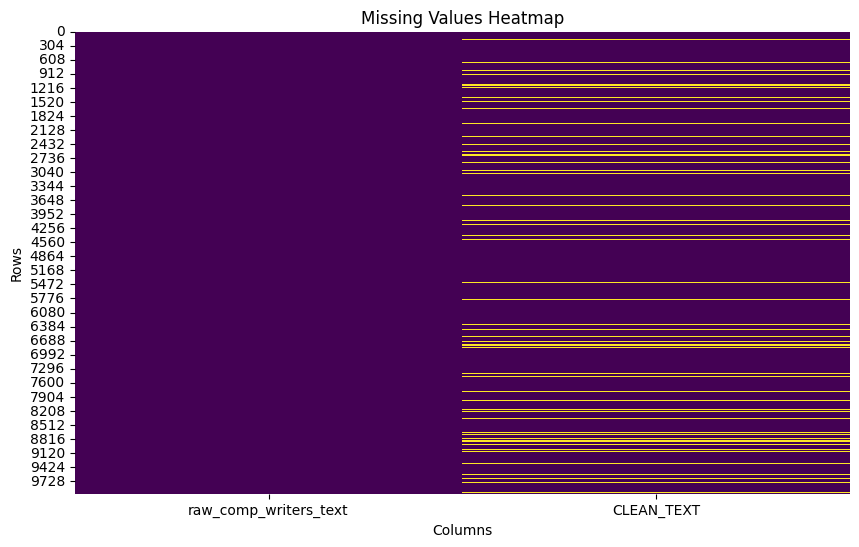

In [7]:
#columns
raw_col = 'raw_comp_writers_text'
clean_col = 'CLEAN_TEXT'

print("\n1. BASIC STATISTICS")
print(f"Dataset size: {len(df):,} samples")

# Count NaNs in each column
column_nan_count = df.isnull().sum().to_dict()
print("\nNaN count per column:")
for col, count in column_nan_count.items():
    print(f" {col}: {count}")

rows_with_nan = df.isnull().any(axis=1).sum()
print(f"\nTotal rows with NaN: {rows_with_nan:,} ({rows_with_nan/len(df)*100:.1f})%")


total_nan_values= int(df.isnull().sum().sum())
print(f"Total missing values: {total_nan_values:,} ({total_nan_values/(2*len(df))*100:.1f})%")


# Unchanged cases
unchanged = (df[raw_col] == df[clean_col]).sum()
print(f"\nRows already normalized: {unchanged:,} ({unchanged/len(df)*100:.1f}%)")
print(f"Rows that need processing: {len(df) - unchanged:,} ({(len(df) - unchanged)/len(df)*100:.1f}%)\n")

# Create a figure and a set of subplots
if True:
  plt.figure(figsize=(10, 6))

# Create the heatmap
  sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

# Set the title and labels
  plt.title('Missing Values Heatmap')
  plt.xlabel('Columns')
  plt.ylabel('Rows')
  plt.savefig("missing.png", dpi=300, bbox_inches="tight")

  plt.show()


## Letter Analysis


2 Letter Analysis

Letter Category Distribution:
category  raw_letters        clean_letters      reduction_%
Latin     234,729 (97.95 %)  195,205 (99.96 %)  16.84      
Other     4,909 (2.05 %)     77 (0.04 %)        98.43      


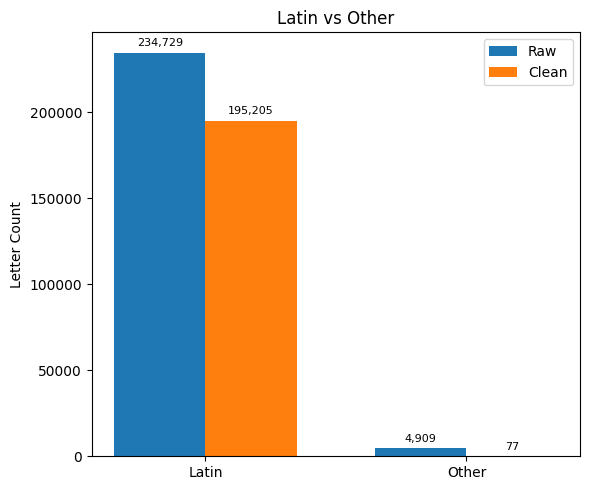

In [8]:
import unicodedata
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

raw_col = "raw_comp_writers_text"   # raw col name
clean_col = "CLEAN_TEXT"            # clean col name

# --- Script detection ---
def detect_category(ch: str) -> str:
    """Return 'Latin' if Latin letter, otherwise 'Other'."""
    try:
        name = unicodedata.name(ch)
    except ValueError:
        return "Unknown"
    if not ch.isalpha():
        return None
    if "LATIN" in name:
        return "Latin"
    return "Other"

def category_counts_for_column(series: pd.Series) -> Counter:
    all_text = " ".join(series.dropna().astype(str))
    return Counter(
        detect_category(ch)
        for ch in all_text
        if detect_category(ch) is not None
    )

# --- Count categories for raw & clean ---
raw_counts = category_counts_for_column(df[raw_col])
clean_counts = category_counts_for_column(df[clean_col])

# --- Ensure both have Latin & Other keys ---
for key in ["Latin", "Other"]:
    raw_counts.setdefault(key, 0)
    clean_counts.setdefault(key, 0)

# --- Totals ---
total_raw_letters = sum(raw_counts.values())
total_clean_letters = sum(clean_counts.values())

# --- Build final table records ---
records = []
for cat in ["Latin", "Other"]:
    raw_val = raw_counts.get(cat, 0)
    clean_val = clean_counts.get(cat, 0)
    change_pct = (1 - clean_val / raw_val) * 100 if raw_val > 0 else 0

    raw_str = f"{raw_val:,} ({(raw_val / total_raw_letters) * 100:.2f} %)" if total_raw_letters else "0 (0.00 %)"
    clean_str = f"{clean_val:,} ({(clean_val / total_clean_letters) * 100:.2f} %)" if total_clean_letters else "0 (0.00 %)"

    records.append((cat, raw_str, clean_str, f"{change_pct:.2f}"))

# --- Determine column widths for alignment ---
header = ["category", "raw_letters", "clean_letters", "reduction_%"]
col_widths = [
    max(len(str(row[i])) for row in records + [tuple(header)])
    for i in range(4)
]

# --- Print nicely aligned ---
print("\n2 Letter Analysis\n")
print("Letter Category Distribution:")
print("  ".join(f"{header[i]:<{col_widths[i]}}" for i in range(4)))
for row in records:
    print("  ".join(f"{row[i]:<{col_widths[i]}}" for i in range(4)))

# --- Save aligned table to file for LaTeX verbatiminput ---
with open("latin.txt", "w", encoding="utf-8") as f:
    f.write("  ".join(f"{header[i]:<{col_widths[i]}}" for i in range(4)) + "\n")
    for row in records:
        f.write("  ".join(f"{row[i]:<{col_widths[i]}}" for i in range(4)) + "\n")

# --- Plot ---
cats = [r[0] for r in records]
raw_vals = [raw_counts.get(cat, 0) for cat in cats]
clean_vals = [clean_counts.get(cat, 0) for cat in cats]

x = np.arange(len(cats))
width = 0.35

fig, ax = plt.subplots(figsize=(6, 5))
rects1 = ax.bar(x - width/2, raw_vals, width, label='Raw')
rects2 = ax.bar(x + width/2, clean_vals, width, label='Clean')

ax.set_ylabel('Letter Count')
ax.set_title('Latin vs Other')
ax.set_xticks(x)
ax.set_xticklabels(cats)
ax.legend()

# Add counts above bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:,}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig("latin.png", dpi=300, bbox_inches="tight")
plt.show()


## Seperator Analysis using n-grams (n=2)

In [9]:
import re
from collections import Counter
import pandas as pd

# --- helpers ---
SEP_RUN_RE = re.compile(r"[^\w\s]+", flags=re.UNICODE)  # runs of consecutive non-word, non-space chars

def _row_sep_ngrams(text: str, n: int) -> Counter:
    c = Counter()
    if not text:
        return c
    for run in SEP_RUN_RE.findall(text):
        if n == 1:
            for ch in run:
                c[ch] += 1
        else:
            if len(run) >= n:
                for i in range(len(run) - n + 1):
                    c[run[i:i+n]] += 1
    return c

def analyze_separators(series: pd.Series, ngram_size: int = 1) -> pd.DataFrame:
    s = series.fillna("").astype(str)
    rows_total = len(s)

    total_counter = Counter()
    rows_with_counter = Counter()

    for text in s:
        ng_counts = _row_sep_ngrams(text, n=ngram_size)
        if ng_counts:
            total_counter.update(ng_counts)
            for ng in ng_counts.keys():
                rows_with_counter[ng] += 1

    records = []
    for sep, total_occ in total_counter.most_common():
        rows_with = int(rows_with_counter.get(sep, 0))
        pct_rows = (rows_with / rows_total * 100.0) if rows_total else 0.0
        records.append({
            "separator": sep,
            "total_occurrences": int(total_occ),
            "rows_with_separator": f"{rows_with} ({pct_rows:.2f} %)",
        })

    # Ensure we always return the expected columns
    if not records:
        return pd.DataFrame(columns=["separator", "total_occurrences", "rows_with_separator"])

    return (pd.DataFrame(records)
            .sort_values("total_occurrences", ascending=False)
            .reset_index(drop=True))

def compare_separator_stats(df: pd.DataFrame, raw_col: str, clean_col: str, ngram_size: int = 1) -> pd.DataFrame:
    raw_tbl  = analyze_separators(df[raw_col], ngram_size=ngram_size).rename(columns={
        "total_occurrences": "total_occ_raw",
        "rows_with_separator": "rows_with_raw"
    })
    clean_tbl = analyze_separators(df[clean_col], ngram_size=ngram_size).rename(columns={
        "total_occurrences": "total_occ_clean",
        "rows_with_separator": "rows_with_clean"
    })

    # If either side has no n-grams, the inner join would be empty anyway
    if raw_tbl.empty or clean_tbl.empty:
        return pd.DataFrame(columns=["separator", "total_occ_raw", "rows_with_raw",
                                     "total_occ_clean", "rows_with_clean"])

    out = pd.merge(raw_tbl, clean_tbl, on="separator", how="inner")
    if out.empty:
        # No common n-grams
        return pd.DataFrame(columns=["separator", "total_occ_raw", "rows_with_raw",
                                     "total_occ_clean", "rows_with_clean"])

    return out.sort_values("total_occ_raw", ascending=False).reset_index(drop=True)

# ---- Usage (loop over n) ----
raw_col = "raw_comp_writers_text"
clean_col = "CLEAN_TEXT"

ngram_list = [1, 2, 3, 4]  # control which n you want

for n in ngram_list:
    title = "Singles" if n == 1 else f"{n}-grams"
    comp = compare_separator_stats(df, raw_col, clean_col, ngram_size=n)

    if comp.empty:
        print(f"No common separator {title.lower()} found (n={n}). Skipping.")
        continue

    print(f"\n🔍 {title} (n={n}) — Raw vs Clean (common):")
    print(comp.head(20).to_string(index=False))

    out_file = f"sep_{n}grams.txt"
    with open(out_file, "w", encoding="utf-8") as f:
        f.write(comp.head(20).to_string(index=False))
    print(f"Saved top 20 {title.lower()} to {out_file}")



🔍 Singles (n=1) — Raw vs Clean (common):
separator  total_occ_raw  rows_with_raw  total_occ_clean rows_with_clean
        /           7773 3998 (39.98 %)             9060  4152 (41.52 %)
        .            986   611 (6.11 %)              741    466 (4.66 %)
        &            981   961 (9.61 %)              137    133 (1.33 %)
        <            344   342 (3.42 %)                1      1 (0.01 %)
        >            344   342 (3.42 %)                2      2 (0.02 %)
        -            319   290 (2.90 %)              227    213 (2.13 %)
        (            271   213 (2.13 %)               54     45 (0.45 %)
        )            263   206 (2.06 %)               54     44 (0.44 %)
        '             91    81 (0.81 %)               74     66 (0.66 %)
        "             44    17 (0.17 %)               24     11 (0.11 %)
        ’             33    32 (0.32 %)               27     27 (0.27 %)
        “             29    23 (0.23 %)               24     19 (0.19 %)
        ”

## Frequent words using n-grams (n=2)


In [10]:
import re
from collections import Counter
import pandas as pd
from typing import List

def analyze_common_ngrams(series: pd.Series, n=1, min_len=2, top_n=20) -> pd.DataFrame:
    """
    Return top N most common n-grams in the given Series.
    - n: 1 for words, 2 for bigrams, 3 for trigrams, ...
    - min_len: minimum length of each token to include
    - top_n: number of top results to show
    """
    text = " ".join(series.dropna().astype(str)).lower()
    tokens = re.findall(r"\b\w+\b", text, flags=re.UNICODE)
    tokens = [t for t in tokens if len(t) >= min_len]

    if n <= 1:
        ngrams: List[str] = tokens
    else:
        if len(tokens) < n:
            return pd.DataFrame(columns=["ngram", "count", "pct %"])
        ngrams = [" ".join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

    counts = Counter(ngrams)
    if not counts:
        return pd.DataFrame(columns=["ngram", "count", "pct %"])

    total = sum(counts.values())
    rows = [{"ngram": ng, "count": cnt, "pct %": round(cnt/total*100, 2)}
            for ng, cnt in counts.most_common(top_n)]
    return pd.DataFrame(rows)

# ---- Loop over n and both columns ----
raw_col = "raw_comp_writers_text"
clean_col = "CLEAN_TEXT"

ngram_list = [1, 2, 3]       # control which n-grams to compute
top_n = 20
min_len = 2
save_txt = True              # set False if you don’t want files

for n in ngram_list:
    for name, col in [("RAW", raw_col), ("CLEAN", clean_col)]:
        df_out = analyze_common_ngrams(df[col], n=n, min_len=min_len, top_n=top_n)
        title = "words" if n == 1 else f"{n}-word phrases"
        if df_out.empty:
            print(f"No {title} found for {name} (n={n}).")
            continue

        print(f"\nTop {title} in {name} (n={n}):")
        print(df_out.to_string(index=False))

        if save_txt:
            fname = f"{name.lower()}_{n}grams_top{top_n}.txt"
            with open(fname, "w", encoding="utf-8") as f:
                f.write(df_out.to_string(index=False))
            print(f"Saved: {fname}")



Top words in RAW (n=1):
     ngram  count  pct %
   unknown    384   0.93
        ca    309   0.75
     music    227   0.55
      john    190   0.46
     david    189   0.46
     james    183   0.44
   michael    181   0.44
 copyright    158   0.38
   control    154   0.37
        pa    153   0.37
        de    136   0.33
       the    136   0.33
    thomas    130   0.31
    daniel    116   0.28
      paul    109   0.26
    robert    103   0.25
publishing     98   0.24
      mark     95   0.23
     chris     85   0.21
   william     84   0.20
Saved: raw_1grams_top20.txt

Top words in CLEAN (n=1):
      ngram  count  pct %
      david    170   0.51
       john    166   0.50
      james    166   0.50
    michael    161   0.48
     thomas    126   0.38
         de    120   0.36
        the    109   0.33
     daniel    109   0.33
       paul    101   0.30
     robert     96   0.29
       mark     86   0.26
         pa     83   0.25
      chris     77   0.23
    william     75   0.22
     

In [12]:
import re
from collections import Counter
import pandas as pd
from typing import List, Tuple, Optional, Set

def _tokenize(series: pd.Series, min_len: int = 2) -> List[str]:
    """Lowercase, regex-tokenize words, and apply a min length filter."""
    all_text = " ".join(series.dropna().astype(str)).lower()
    words = re.findall(r"\b\w+\b", all_text, flags=re.UNICODE)
    return [w for w in words if len(w) >= min_len]

def _make_ngrams(tokens: List[str], n: int) -> List[Tuple[str, ...]]:
    """Build n-grams as tuples."""
    if n <= 1:
        return [(t,) for t in tokens]
    if len(tokens) < n:
        return []
    return [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]

def _format_ngram(ng: Tuple[str, ...]) -> str:
    """Join an n-gram tuple for display."""
    return " ".join(ng)

def common_ngrams_not_in_other(
    df: pd.DataFrame,
    col_a: str,
    col_b: str,
    n: int = 1,
    top_n: int = 30,
    min_len: int = 2,
    stopwords: Optional[Set[str]] = None,
) -> pd.DataFrame:
    """
    Find the most common n-grams in col_a that do NOT appear at all in col_b.
    - n: 1 for unigrams, 2 for bigrams, etc.
    - min_len: per-token minimum length (applied before n-gramming)
    - stopwords: optional set of tokens to drop (lowercased)
    """
    tokens_a = _tokenize(df[col_a], min_len=min_len)
    tokens_b = _tokenize(df[col_b], min_len=min_len)

    if stopwords:
        sw = {w.lower() for w in stopwords}
        tokens_a = [t for t in tokens_a if t not in sw]
        tokens_b = [t for t in tokens_b if t not in sw]

    ngrams_a = _make_ngrams(tokens_a, n)
    ngrams_b = _make_ngrams(tokens_b, n)
    if not ngrams_a:
        return pd.DataFrame(columns=["ngram", "count", "pct"])

    ngrams_b_set = set(ngrams_b)
    filtered = [ng for ng in ngrams_a if ng not in ngrams_b_set]
    if not filtered:
        return pd.DataFrame(columns=["ngram", "count", "pct"])

    counts = Counter(filtered)
    total = sum(counts.values()) or 1

    rows = [{
        "ngram": _format_ngram(ng),
        "count": cnt,
        "pct %": round(cnt / total * 100, 2),
    } for ng, cnt in counts.most_common(top_n)]
    return pd.DataFrame(rows)

# ----------------- LOOP DRIVER -----------------
raw_col = "raw_comp_writers_text"
clean_col = "CLEAN_TEXT"

ngram_list = [1, 2, 3]     # change as you like
top_n = 100
min_len = 2
save_txt = True
stopwords = None  # e.g., {"and","the","of","feat","featuring"}

def run_diff_tables(df: pd.DataFrame, n_values, a_name, col_a, b_name, col_b):
    for n in n_values:
        title = "words" if n == 1 else f"{n}-word phrases"
        out = common_ngrams_not_in_other(
            df, col_a, col_b, n=n, top_n=top_n, min_len=min_len, stopwords=stopwords
        )
        if out.empty:
            print(f"No {title} unique to {a_name} vs {b_name} (n={n}).")
            continue
        print(f"\nTop {title} in {a_name} NOT appearing in {b_name} (n={n}):")
        print(out.to_string(index=False))
        if save_txt:
            fname = f"{a_name.lower()}_not_in_{b_name.lower()}_{n}grams_top{top_n}.txt"
            out.to_string(index=False)
            with open(fname, "w", encoding="utf-8") as f:
                f.write(out.to_string(index=False))
            print(f"Saved: {fname}")

# RAW-only (vs CLEAN)
run_diff_tables(df, ngram_list, "RAW", raw_col, "CLEAN", clean_col)

# (Optional) CLEAN-only (vs RAW)
#run_diff_tables(df, ngram_list, "CLEAN", clean_col, "RAW", raw_col)



Top words in RAW NOT appearing in CLEAN (n=1):
        ngram  count  pct %
          bmi     32   1.02
        ascap     20   0.64
    universal     18   0.57
         gmbh     18   0.57
         sony     14   0.44
          llc     13   0.41
           kg     12   0.38
          prs      8   0.25
    александр      8   0.25
      company      7   0.22
       андрей      7   0.22
          김홍중      7   0.22
          송민기      7   0.22
      limited      6   0.19
        audio      6   0.19
   industries      6   0.19
         corp      6   0.19
      sonoton      6   0.19
           dp      6   0.19
         олег      5   0.16
       author      5   0.16
         tips      5   0.16
        ateez      5   0.16
        ultra      5   0.16
        trang      5   0.16
          emi      5   0.16
        minds      5   0.16
           nm      5   0.16
          pub      4   0.13
         sgae      4   0.13
 unaffiliated      4   0.13
           ms      4   0.13
        cloud      4   0.13


In [14]:
#stopword_set = set(pd.read_csv("raw_not_in_clean_1grams_top20.txt", sep=r"\s+", engine="python")["ngram"])


In [15]:
import pandas as pd

def load_first_col(path: str) -> list[str]:
    # reads "word/ngram  [2+ spaces]  count  [2+ spaces]  pct..."
    df = pd.read_csv(path, sep=r"\s{2,}", engine="python")
    first_col = df.columns[0]          # e.g., "ngram" or "word"
    return df[first_col].astype(str).str.strip().tolist()

# Examples
raw_ngrams = load_first_col("raw_not_in_clean_1grams_top100.txt")+load_first_col("raw_not_in_clean_2grams_top100.txt")+load_first_col("raw_not_in_clean_3grams_top100.txt")
raw_ngrams.append("copyright control")
set(raw_ngrams)

{'2020',
 'acuff',
 'acuff rose',
 'acuff rose music',
 'aepi',
 'america',
 'america obo',
 'anh việt thu',
 'ar haavisto janne',
 'arvo obo',
 'arvo obo gema',
 'ascap',
 'ateez',
 'audio',
 'author',
 'bazli unic copyright',
 'billionaire',
 'billionaire minds',
 'billionaire minds group',
 'bmi',
 'bmi adminstered',
 'bmi adminstered by',
 'buddy eden',
 'bv',
 'ca assaf youhanna',
 'ca calcagni filippo',
 'ca dixon lance',
 'ca granberg marcus',
 'ca jacobsen',
 'ca kan van',
 'ca masseling danny',
 'ca nitzan',
 'ca nitzan raz',
 'ca williams',
 'calcagni filippo ca',
 'chappell music',
 'christos giannakopoulos',
 'cloud',
 'cloud holland',
 'cloud holland music',
 'cmrra',
 'co kg',
 'co kg figurata',
 'co paert',
 'co paert arvo',
 'company',
 'composer author',
 'control angel',
 'control francisco',
 'control prs',
 'control unknown',
 'copyright control',
 'copyright control adam',
 'copyright control angel',
 'copyright control lopez',
 'copyright control prs',
 'copyright

# Phase 1: Rule based approach

In [16]:
df

,raw_comp_writers_text,CLEAN_TEXT
0,Jordan Riley/Adam Argyle/Martin Brammer,Jordan Riley/Adam Argyle/Martin Brammer
1,Martin Hygård,Martin Hygård
2,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...
3,Mendel Brikman,NaN
4,Alvin Lee,Alvin Lee
...,...,...
9995,Terrance Byrd,Terrance Byrd
9996,Pillar Point,Pillar Point
9997,FRANK BRIAN KEITH (MR)/JENNINGS JOHN JOSEPH IV...,FRANK/BRIAN/KEITH/(MR)/JENNINGS/JOHN/JOSEPH/IV...
9998,Sierra Lucas,Sierra Lucas


In [17]:
#First we drop the Nan values
df_rb = df.copy()
df_rb = df_rb.dropna()
df_rb

,raw_comp_writers_text,CLEAN_TEXT
0,Jordan Riley/Adam Argyle/Martin Brammer,Jordan Riley/Adam Argyle/Martin Brammer
1,Martin Hygård,Martin Hygård
2,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...
4,Alvin Lee,Alvin Lee
5,Haddag Samir/MusicAlligator,Haddag Samir
...,...,...
9995,Terrance Byrd,Terrance Byrd
9996,Pillar Point,Pillar Point
9997,FRANK BRIAN KEITH (MR)/JENNINGS JOHN JOSEPH IV...,FRANK/BRIAN/KEITH/(MR)/JENNINGS/JOHN/JOSEPH/IV...
9998,Sierra Lucas,Sierra Lucas


In [20]:
import re
import pandas as pd
import unicodedata
import re

NON_LATIN_RE = re.compile(r"[^\W\d_]", flags=re.UNICODE)  # letters only (no digits, no _)
CLEAN_COL = "CLEAN_TEXT"





def strip_non_latin(text: str) -> str:
    """
    Remove letters that are not from the LATIN script.
    Keeps digits, punctuation, spaces. Collapses extra spaces at the end.
    """
    if not isinstance(text, str):
        return text

    out_chars = []
    for ch in text:
        # if it's not a letter, keep it (digits/punct/space)
        if not ch.isalpha():
            out_chars.append(ch)
            continue
        # keep only LATIN letters
        if "LATIN" in unicodedata.name(ch, ""):
            out_chars.append(ch)
        # else drop non-Latin letters
    out = "".join(out_chars)
    return re.sub(r"\s+", " ", out).strip()

# Define a single function that combines all previous normalization steps
def normalize_text_full(text):
    """
    Combines all normalization steps: removes HTML-like tags, leading slashes,
    and replaces '&', ' and ', and ', ' with a forward slash.
    """
    if pd.isnull(text):
        return text

    text = str(text)
    text = strip_non_latin(text)
    # List of publisher/metadata strings to remove
   # metadata_to_remove = list(raw_bigrams)
    # Sort by number of words (desc) so longer phrases are matched first
    metadata_to_remove = sorted(raw_ngrams, key=lambda x: len(x.split()), reverse=True)

# Escape special regex characters in each term
    escaped_terms = [re.escape(term) for term in metadata_to_remove]

# Build regex pattern with word boundaries
    pattern = r'\b(?:' + '|'.join(escaped_terms) + r')\b'
    #print(pattern)
    # Apply existing rules
    text = re.sub(r'<.*?>', '', text)
    text = text.lstrip('/').strip()
    text = re.sub(r'\s*&\s*', '/', text, flags=re.IGNORECASE)
    text = re.sub(r'\b and \b', '/', text, flags=re.IGNORECASE)
    text = re.sub(r', ', '/', text)
    text = re.sub(r',', '/', text)
    text = re.sub(r'//', '/', text)

    # New rule: Remove publisher and metadata strings
    text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    # Final cleanup of multiple slashes and whitespace
    text = re.sub(r'/+', '/', text)
    text = text.strip('/ ').strip()

    return text



def exact_match_accuracy(y_true, y_pred):
    """Exact match accuracy between two lists of strings."""
    correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
    return correct / len(y_true) if y_true else 0.0


from collections import Counter  # add this import

def token_f1_score(y_true, y_pred):
    """
    Token-level F1 (macro over samples).
    We treat each text as a multiset of whitespace-split tokens.
    """
    scores = []
    for t, p in zip(y_true, y_pred):
        true_tokens = str(t).split()
        pred_tokens = str(p).split()

        ct = Counter(true_tokens)
        cp = Counter(pred_tokens)

        overlap = sum((ct & cp).values())
        precision = overlap / len(pred_tokens) if pred_tokens else 0.0
        recall    = overlap / len(true_tokens) if true_tokens else 0.0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0
        scores.append(f1)

    return sum(scores) / len(scores) if scores else 0.0

df_rb["PHASE1_RULEBASED"] = df_rb["raw_comp_writers_text"].apply(normalize_text_full)

y_true = df_rb[CLEAN_COL].astype(str).tolist()
y_pred = df_rb["PHASE1_RULEBASED"].astype(str).tolist()

acc = exact_match_accuracy(y_true, y_pred)
f1 = token_f1_score(y_true, y_pred)

print(f"Exact Match Accuracy: {acc*100:.2f}%")
print(f"Token-level F1:       {f1*100:.2f}%")




Exact Match Accuracy: 87.33%
Token-level F1:       92.03%


In [21]:
df_rb

,raw_comp_writers_text,CLEAN_TEXT,PHASE1_RULEBASED
0,Jordan Riley/Adam Argyle/Martin Brammer,Jordan Riley/Adam Argyle/Martin Brammer,Jordan Riley/Adam Argyle/Martin Brammer
1,Martin Hygård,Martin Hygård,Martin Hygård
2,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...
4,Alvin Lee,Alvin Lee,Alvin Lee
5,Haddag Samir/MusicAlligator,Haddag Samir,Haddag Samir/MusicAlligator
...,...,...,...
9995,Terrance Byrd,Terrance Byrd,Terrance Byrd
9996,Pillar Point,Pillar Point,Pillar Point
9997,FRANK BRIAN KEITH (MR)/JENNINGS JOHN JOSEPH IV...,FRANK/BRIAN/KEITH/(MR)/JENNINGS/JOHN/JOSEPH/IV...,FRANK BRIAN KEITH (MR)/JENNINGS JOHN JOSEPH IV...
9998,Sierra Lucas,Sierra Lucas,Sierra Lucas


# Phase 2: NER

In [35]:
import re
from difflib import SequenceMatcher
import spacy

RAW_COL = "raw_comp_writers_text"
nlp = spacy.load("en_core_web_sm", disable=["lemmatizer","textcat"])
nlp.max_length = 2_000_000
raw_texts = df_rb[RAW_COL].fillna("").astype(str).tolist()

ner_lists = []
for doc in nlp.pipe(raw_texts, batch_size=128, n_process=1):  # increase n_process (e.g., 4) if your env supports it
    names = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    ner_lists.append(names)

def _clean_name(s: str) -> str:
    # normalize spaces and stray slashes around the name
    s = re.sub(r"\s*/+\s*", "/", s)         # collapse internal slashes
    s = re.sub(r"\s+", " ", s).strip(" /")  # trim spaces + edge slashes
    return s

def _clean_ner_piece(s: str) -> str:
    # same as _clean_name + trim connector tokens at edges
    s = _clean_name(s)
    s = re.sub(r'^(?:&|and|/|,|\+)\s*', '', s, flags=re.IGNORECASE)  # leading
    s = re.sub(r'\s*(?:&|and|/|,|\+)$', '', s, flags=re.IGNORECASE)  # trailing
    return s.strip()

def _key(s: str) -> str:
    return re.sub(r"\s+", " ", s).strip().lower()

def _tokenset(s: str) -> set[str]:
    return set(re.findall(r"[A-Za-z]+", s.lower()))

def _align_ner_to_p1(ner_parts, p1_parts, thresh=0.92):
    """If a NER span is ~the same as a Phase-1 name, use the Phase-1 variant."""
    aligned = []
    for n in ner_parts:
        best = n
        best_ratio = 0.0
        n_low = n.lower()
        for p in p1_parts:
            r = SequenceMatcher(None, n_low, p.lower()).ratio()
            if r > best_ratio:
                best_ratio, best = r, p
        aligned.append(best if best_ratio >= thresh else n)
    return aligned

phase1_preds = df_rb["PHASE1_RULEBASED"].astype(str).tolist()
raw_texts    = df_rb[RAW_COL].fillna("").astype(str).tolist()

phase2_preds = []
for raw, p1, ner_names in zip(raw_texts, phase1_preds, ner_lists):
    # 1) Clean & split
    p1_parts  = [_clean_name(x) for x in re.split(r"\s*/\s*", p1) if _clean_name(x)]
    ner_parts = [_clean_ner_piece(x) for x in ner_names if _clean_ner_piece(x)]

    # 2) Prefer Phase-1 variant when nearly identical
    ner_parts = _align_ner_to_p1(ner_parts, p1_parts, thresh=0.92)

    # 3) True union (NER first, then Phase-1) with case-insensitive dedupe
    seen, candidates = set(), []
    for s in ner_parts + p1_parts:
        k = _key(s)
        if k in seen:
            continue
        seen.add(k)
        candidates.append(s)

    if not candidates:
        phase2_preds.append(p1)
        continue

    # 4) Collapse partial duplicates: prefer longer token sets
    candidates_sorted = sorted(candidates, key=lambda x: (len(_tokenset(x)), len(x)), reverse=True)
    kept, kept_tokens = [], []
    for c in candidates_sorted:
        tc = _tokenset(c)
        if any(tc.issubset(kts) for kts in kept_tokens):
            continue
        kept.append(c)
        kept_tokens.append(tc)

    # 5) Order by first appearance in RAW (natural order)
    def first_idx(name: str) -> int:
        m = re.search(re.escape(name), raw, flags=re.IGNORECASE)
        return m.start() if m else 10**9

    kept.sort(key=first_idx)

    # 6) Join safely
    pred = "/".join(kept)
    pred = re.sub(r"/+", "/", pred).strip("/")
    phase2_preds.append(pred if pred else p1)

df_rb["PHASE2_UNION"] = phase2_preds


# Evaluate
y_true = df_rb["CLEAN_TEXT"].astype(str).tolist()
y_pred = df_rb["PHASE2_UNION"].astype(str).tolist()
acc2   = exact_match_accuracy(y_true, y_pred)
f12    = token_f1_score(y_true, y_pred)

print("Phase 2 (Union with true dedupe & partial-dupe collapse)")
print(f"   Exact Match Accuracy: {acc2*100:.2f}%")
print(f"   Token-level F1:       {f12*100:.2f}%")


Phase 2 (Union with true dedupe & partial-dupe collapse)
   Exact Match Accuracy: 83.02%
   Token-level F1:       90.73%


In [36]:
df_rb

,raw_comp_writers_text,CLEAN_TEXT,PHASE1_RULEBASED,PHASE2_UNION
0,Jordan Riley/Adam Argyle/Martin Brammer,Jordan Riley/Adam Argyle/Martin Brammer,Jordan Riley/Adam Argyle/Martin Brammer,Jordan Riley/Adam Argyle/Martin Brammer
1,Martin Hygård,Martin Hygård,Martin Hygård,Martin Hygård
2,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...
4,Alvin Lee,Alvin Lee,Alvin Lee,Alvin Lee
5,Haddag Samir/MusicAlligator,Haddag Samir,Haddag Samir/MusicAlligator,Haddag Samir/MusicAlligator
...,...,...,...,...
9995,Terrance Byrd,Terrance Byrd,Terrance Byrd,Terrance Byrd
9996,Pillar Point,Pillar Point,Pillar Point,Pillar Point
9997,FRANK BRIAN KEITH (MR)/JENNINGS JOHN JOSEPH IV...,FRANK/BRIAN/KEITH/(MR)/JENNINGS/JOHN/JOSEPH/IV...,FRANK BRIAN KEITH (MR)/JENNINGS JOHN JOSEPH IV...,FRANK BRIAN KEITH (MR)/JENNINGS JOHN JOSEPH IV...
9998,Sierra Lucas,Sierra Lucas,Sierra Lucas,Sierra Lucas


In [37]:
diff_df = df_rb[df_rb["PHASE1_RULEBASED"] != df_rb["PHASE2_UNION"]]

# Show a few columns for inspection
#print(diff_df[[RAW_COL, "PHASE1_RULEBASED", "PHASE2_UNION"]].to_string(index=False))

# Optional: how many differ
print(f"\nNumber of differing rows: {len(diff_df)}")


Number of differing rows: 728


In [38]:
diff_df

,raw_comp_writers_text,CLEAN_TEXT,PHASE1_RULEBASED,PHASE2_UNION
63,Adam Pék/Cory James/Various Artists/Copyright...,Various Artists/Nick Sinna,Adam Pék/Cory James/Various Artists/ ()/Nick ...,Adam Pék/Cory James/Various Artists/PRS)/Nick...
92,Tiê/Rita Wainer/André Whoong/Adriano Cintra/Gi...,Tiê/Rita Wainer/André Whoong/Adriano Cintra/Gi...,Tiê/Rita Wainer/André Whoong/Adriano Cintra/Gi...,Tiê/Rita Wainer/André Whoong/ré Whoong/Adriano...
103,Jan Peter Aaberg/Ronny Aake Johansson,Jan Peter Aaberg/Ronny Aake Johansson,Jan Peter Aaberg/Ronny Aake Johansson,Jan Peter Aaberg/Peter Aaberg/Ronny Aake Johan...
105,Ruedi Rymann/Copyright Control,Ruedi Rymann,Ruedi Rymann,Ruedi Rymann/Copyright Control
114,Martin Landsky/Ed. Starbug/Rückbank,Martin Landsky/Ed. Starbug/Rückbank,Martin Landsky/Ed. Starbug/Rückbank,Martin Landsky/Ed/Ed. Starbug/Rückbank
...,...,...,...,...
9950,Andreas Wulkan/Markus Nilsson/Markus Åkesson/A...,Andreas Wulkan/Markus Nilsson/Markus Åkesson/A...,Andreas Wulkan/Markus Nilsson/Markus Åkesson/A...,reas Wulkan/Markus Nilsson/Markus Åkesson/Andr...
9959,Jesse Walton/Audio Network Ltd,Jesse Walton,Jesse Walton/ Ltd,Jesse Walton/Ltd
9971,Andy Shearman/John Dirne/Daniel Gibson/Han Koo...,Andy Shearman/John Dirne/Daniel Gibson/Han Koo...,Andy Shearman/John Dirne/Daniel Gibson/Han Koo...,Andy Shearman/y Shearman/John Dirne/Daniel Gib...
9993,Jonny Buckland/Guy Berryman/Will Champion/Chri...,Jonny Buckland/Guy Berryman/Will Champion/Chri...,Jonny Buckland/Guy Berryman/Will Champion/Chri...,Jonny Buckland/Jonny Buckl/Guy Berryman/Will C...
